# 🧪 Lab 11: Time Series Forecasting with Retail Sales Data

**Objective**: Forecast future retail sales using time series models and evaluate their performance.

**Theory**:
- Time series data consists of observations collected sequentially over time.
- Key components: trend, seasonality, and residual noise.
- ARIMA (AutoRegressive Integrated Moving Average) is a classical model for forecasting stationary time series.
- Prophet is a flexible model developed by Meta for forecasting with seasonality and holidays.
- Evaluation metrics include MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error).

Data source: https://www.kaggle.com/datasets/mohammadtalib786/retail-sales-dataset


In [5]:
# 📥 Step 1: Automatically download and load the dataset
import pandas as pd
import requests

# Download sample retail sales data (monthly)
url = "retail_sales_dataset.csv"
df = pd.read_csv(url)
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


## 🧹 Step 2: Preprocess the data
- Convert date column to datetime format
- Set date as index
- Resample to monthly frequency if needed

<Axes: title={'center': 'Monthly Retail Sales'}, xlabel='Month'>

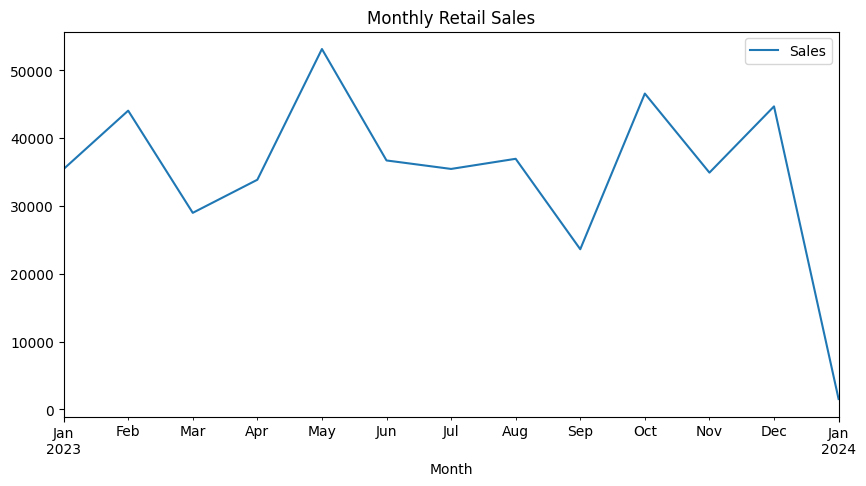

In [6]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate 'Total Amount' by month
# Using pd.Grouper to group by month start frequency and sum 'Total Amount'
df_ts = df.groupby(pd.Grouper(key='Date', freq='MS'))['Total Amount'].sum().to_frame()

# Rename the aggregated column to 'Sales'
df_ts.rename(columns={'Total Amount': 'Sales'}, inplace=True)

# Rename the index to 'Month' for consistency with later Prophet cell
df_ts.index.name = 'Month'

# Assign the aggregated time series DataFrame back to 'df'
df = df_ts

# Plot monthly Retail Sales
df.plot(title="Monthly Retail Sales", figsize=(10, 5))

## 📉 Step 3: Apply ARIMA model
ARIMA requires stationary data, so we difference the series and fit the model.

<Axes: title={'center': 'ARIMA Forecast vs Actual'}, xlabel='Month'>

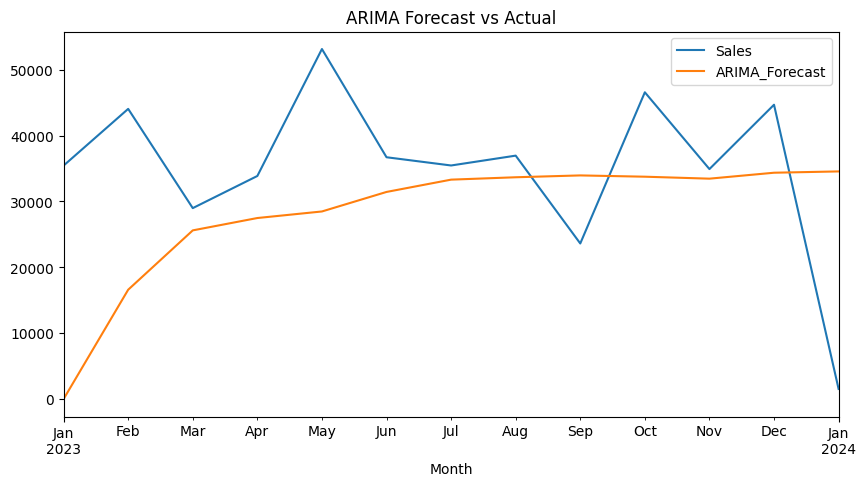

In [7]:
# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Sales'], order=(1,1,1))  # ARIMA(p,d,q)
results = model.fit()
df['ARIMA_Forecast'] = results.predict(start=0, end=len(df)-1, typ='levels')

# Plot forecast
df[['Sales', 'ARIMA_Forecast']].plot(title="ARIMA Forecast vs Actual", figsize=(10, 5))

## 🔮 Step 4: Apply Prophet model
Prophet handles seasonality and missing dates automatically.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.


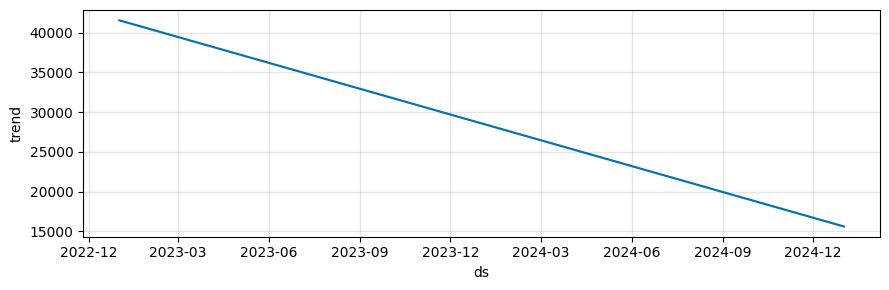

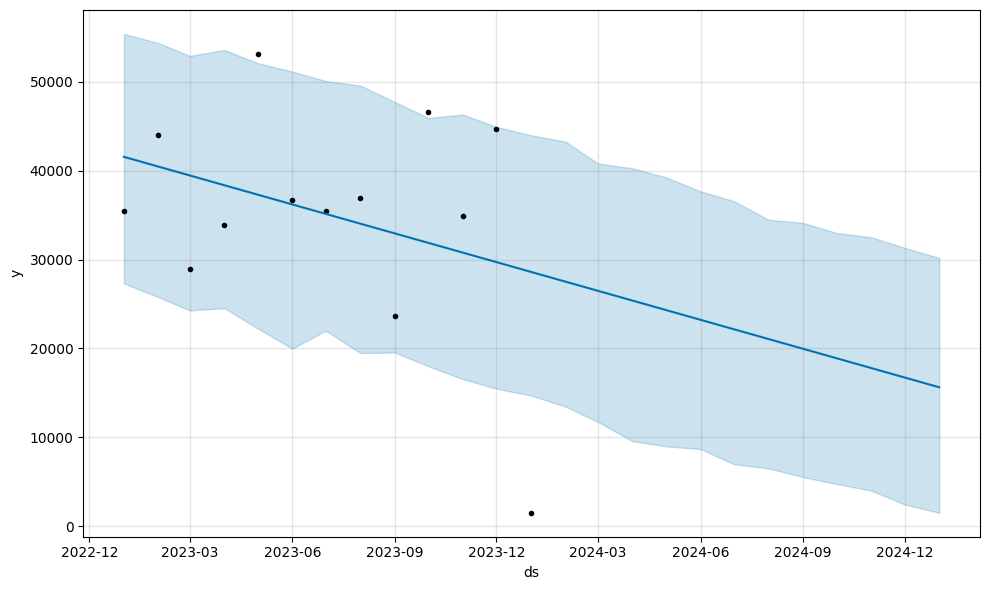

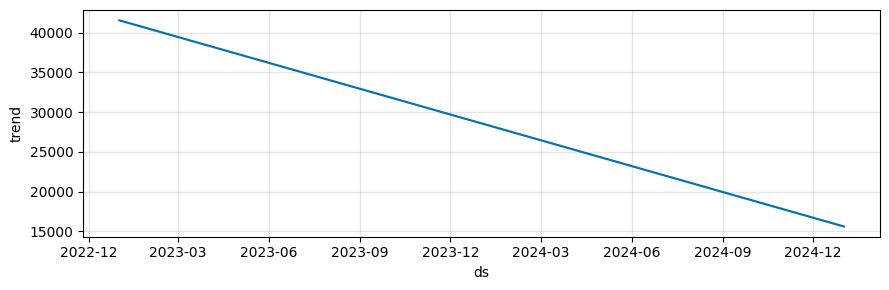

In [8]:
# Prepare data for Prophet
from prophet import Prophet
df_prophet = df.reset_index()[['Month', 'Sales']].rename(columns={'Month': 'ds', 'Sales': 'y'})

# Fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Forecast future 12 months
future = model_prophet.make_future_dataframe(periods=12, freq='MS')
forecast = model_prophet.predict(future)

# Plot forecast
model_prophet.plot(forecast)
model_prophet.plot_components(forecast)

## 📊 Step 5: Evaluate forecast accuracy
We use MAE and RMSE to compare ARIMA and Prophet performance.

In [10]:
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ARIMA
mae_arima = mean_absolute_error(df['Sales'], df['ARIMA_Forecast'])
rmse_arima = np.sqrt(mean_squared_error(df['Sales'], df['ARIMA_Forecast']))

# Prophet (only on historical period)
merged = pd.merge(df.reset_index(), forecast[['ds', 'yhat']], left_on='Month', right_on='ds')
mae_prophet = mean_absolute_error(merged['Sales'], merged['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(merged['Sales'], merged['yhat']))

print("ARIMA MAE:", round(mae_arima, 2))
print("ARIMA RMSE:", round(rmse_arima, 2))
print("Prophet MAE:", round(mae_prophet, 2))
print("Prophet RMSE:", round(rmse_prophet, 2))

ARIMA MAE: 13539.94
ARIMA RMSE: 17943.95
Prophet MAE: 8808.48
Prophet RMSE: 11496.97


## 📝 Reflection Questions

1. What are the key differences between ARIMA and Prophet?
2. How does seasonality affect retail sales forecasting?
3. Which model performed better in this case, and why?
4. How could this forecasting approach support inventory or staffing decisions?